## Declaração de bibliotecas e demais configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import csv
import matplotlib.gridspec as gridspec

import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

#from matplotlib import rcParams
#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Funções relacionadas ao método ou auxiliares

In [2]:
#Função de leitura dos dados------------------------------------
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack( (data , np.asarray(row).astype(np.float) ) )
            except:
                data = np.asarray(row).astype(np.float)
    f.close()
    y = data[:,0]
    x = data[:,1:]
    return y,x

## Leitura dos dados
* Os dados considerados aqui foram obtidos da USGS (http://www.dartmouth.edu)

* Atributos são:
    * latitude
    * longitude
    * depth
    * mag
    * gap
    * dmin
    * rms
    * horizontalError
    * depthError

* Classes:
    * 1 - MB; (azul escuro)
    * 2 - MD; (ciano)
    * 3 - ML; (verde)
    * 4 - MW; (laranja)
    
##### Definição dos atributos em: https://earthquake.usgs.gov/data/comcat/data-eventterms.php
##### Definição das classes em: https://www.usgs.gov/natural-hazards/earthquake-hazards/science/magnitude-types

In [3]:
#Dados
path = 'EartQuakes_USGS_mar-abr2020.csv'

#Leitura dos dados
y,x = read_class_data(path)

## Suposição/motivação para classificação binária
* Há grande interesse na classe 'ML', sua ocorrência será julgada "condição verdadeira"
* Em relação as demais classes, quando ocorrem implicam "condição falsa" (para a classe ML)

In [4]:
posTrue = np.where(y == 3)
yBin = np.zeros(y.shape[0])
yBin[posTrue] = 1

## Visualizacão dos dados de treino/avaliação

/home/rogerio/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


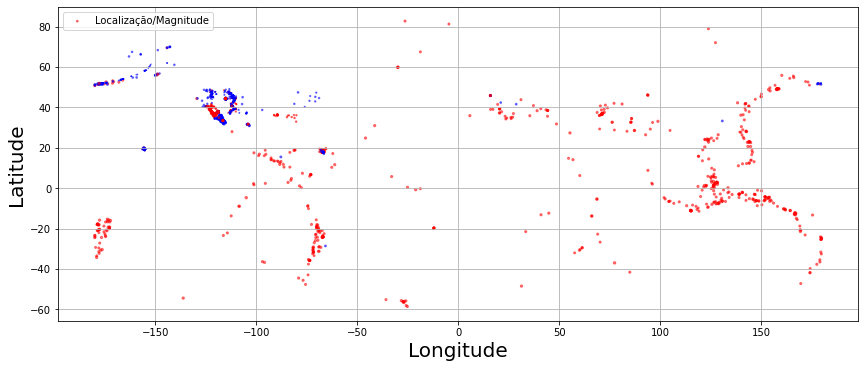

In [5]:
classColor = ['red','blue']
vecCol = []
for i in yBin: vecCol.append( classColor[int(i)] )    

FS = (15,5) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

ax.scatter( x[:,1], x[:,0], s=x[:,3], c=vecCol, alpha=0.5, label='Localização/Magnitude')
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

ax.set_aspect('equal', 'box')

ax.legend(fontsize=10)
ax.grid(True)

## Normalização e separação aleatória dos dados para treinamento e avaliação

In [7]:
#Normalização dos atributos
x = preprocessing.normalize(x, axis=0, norm='max')

#Gerar conjunto de treino e avaliação a partir de uma única fonte
#N = y.shape[0]
percentAvalia = 0.33

#Seleção de dados de treinamento e avaliação
xD, xI, yD, yI = train_test_split(x,yBin,test_size=percentAvalia)

## Escolha dos atributos e normalização dos dados (pelo máximo)

In [8]:
#0 - latitude, 1 - longitude, 2 - depth, 3 - mag
#4 - gap, 5 - dmin, 6 - rms, 7 - horizontalError, 8 - depthError
#atributos = [0,1,2,3] #Permite escolhar qual atributo usar
atributos = [2,3,4,5,6,7,8] #Permite escolhar qual atributo usar
xD_sub = xD[:,atributos]
xI_sub = xI[:,atributos]

## Classificação dos dados
* SVM (kernel Linear e RBF)
* Rnadom Forest

In [9]:
#Instanciação dos classificadores
svmRBF = svm.SVC(C=100, kernel='rbf', gamma=2.5, decision_function_shape='ovr')
RF = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=10, min_impurity_decrease=10**(-5))

#Treinamento dos classificadores 
svmRBF.fit(xD_sub,yD)
RF.fit(xD_sub,yD)

#Aplicação
yEst_svmRBF = svmRBF.predict(xI_sub)
yEst_RF = RF.predict(xI_sub)

## Avaliação do desempenho
* Tabela de contingência (matriz de confusão) para o caso binário
* Precison, Recall, F1-Score
* MCC

In [10]:
#SVM+RBF
tab_svmRBF = confusion_matrix(yI, yEst_svmRBF)
f1_svmRBF = f1_score(yI, yEst_svmRBF)
f2_svmRBF = fbeta_score(yI, yEst_svmRBF, beta=2)
mcc_svmRBF = matthews_corrcoef(yI, yEst_svmRBF)

#RF
tab_RF = confusion_matrix(yI, yEst_RF)
f1_RF = f1_score(yI, yEst_RF)
f2_RF = fbeta_score(yI, yEst_RF, beta=2)
mcc_RF = matthews_corrcoef(yI, yEst_RF)

print('---SVM com kernel Linear---')
print('F1-Score:       ',f1_svmRBF)
print('Fbeta (beta=2): ',f2_svmRBF)
print('MCC:            ',mcc_svmRBF)
print(tab_svmRBF)
print('')

print('---Random Forest---')
print('F1-Score:       ',f1_RF)
print('Fbeta (beta=2): ',f2_RF)
print('MCC:            ',mcc_RF)
print(tab_RF)
print('')

---SVM com kernel Linear---
F1-Score:        0.8865979381443299
Fbeta (beta=2):  0.904338420862877
MCC:             0.7333913005351101
[[1043  248]
 [ 137 1505]]

---Random Forest---
F1-Score:        0.9113697403760072
Fbeta (beta=2):  0.9224356650960491
MCC:             0.7942515377160329
[[1109  182]
 [ 115 1527]]



In [ ]:
#Lembrete....
#Organização da matriz de True/False Pos./Neg.
#-----------
#| TN | FP |
#| FN | TP |
#-----------